# ResNet-based model with CIFAR-10

### Imports and dataset init

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import random
import os

In [2]:
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. You can use GPU for PyTorch.")
else:
    print("CUDA is not available. Using CPU for PyTorch.")

CUDA is available. You can use GPU for PyTorch.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data Augmentation

In [4]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    # transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [5]:
full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform_train)

# Creating train/vali split
train_size = int(0.8 * len(full_trainset))
val_size = len(full_trainset) - train_size
trainset, valset = random_split(full_trainset, [train_size, val_size])

valset.dataset.transform = transform_test  # For validation we switch to transform_test (no augmentation)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform_test)

In [6]:
batch_size = 64

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

### Building CNN

In [32]:
resnet = models.resnet18(pretrained=True)

# for param in resnet.parameters():
#     param.requires_grad = False

num_ftrs = resnet.fc.in_features
# resnet.fc = nn.Linear(num_ftrs, 10)
resnet.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(512, 10)
)

In [33]:
model = resnet.to(device)

learning_rate = 0.0005

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)

### Training loop

In [ ]:
num_epochs = 200
train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    scheduler.step()

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
    
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    val_losses.append(epoch_val_loss)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}")
    
    if epoch > 75:
        if np.mean(train_losses[-20:]) - train_losses[-1] < 0.0002 or val_losses[-1] - np.mean(val_losses) > 0.3:
            print(f"Early stopping at epoch [{epoch}/{num_epochs}] due to minimal training loss decrease. Final training loss: {epoch_loss:.6f}, Final validation loss: {epoch_val_loss:.6f}")
            break

KeyboardInterrupt: 

In [ ]:
# Added f1-score evaluation and early stopping
num_epochs = 200
train_losses = []
val_losses = []

best_val_f1 = 0
patience = 20  # Number of epochs to wait for f1-score improvement before early stopping

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    
    scheduler.step()

    epoch_loss = running_loss / len(trainloader.dataset)
    train_losses.append(epoch_loss)

    model.eval()
    val_running_loss = 0.0
    all_val_preds = []
    all_val_labels = []
    
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels.cpu().numpy())
    
    epoch_val_loss = val_running_loss / len(valloader.dataset)
    epoch_val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Training Loss: {epoch_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}, Validation F1-Score: {epoch_val_f1:.4f}")
    
    if epoch > 50:
        if epoch_val_f1 > best_val_f1:
            best_val_f1 = epoch_val_f1
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print("\n*Early stopping triggered: no improvement in validation F1-Score for 10 consecutive epochs.*")
                print(f"Epoch [{epoch}/{num_epochs}], Final Training Loss: {epoch_loss:.6f}, Final Validation Loss: {epoch_val_loss:.6f}, Final Validation F1-Score: {epoch_val_f1:.4f}")
                break

        if val_losses[-1] - np.mean(val_losses) > 0.2:
            print(f"\n*Early stopping triggered: validation loss increase above threshold.*")
            print(f"Epoch [{epoch}/{num_epochs}], Final training loss: {epoch_loss:.6f}, Final validation loss: {epoch_val_loss:.6f}")")
            break

Epoch [10/200], Training Loss: 0.063669, Validation Loss: 0.364412, Validation F1-Score: 0.9061
Epoch [20/200], Training Loss: 0.012292, Validation Loss: 0.396392, Validation F1-Score: 0.9251
Epoch [30/200], Training Loss: 0.012025, Validation Loss: 0.423325, Validation F1-Score: 0.9200
Epoch [40/200], Training Loss: 0.002380, Validation Loss: 0.463041, Validation F1-Score: 0.9304
Epoch [50/200], Training Loss: 0.000976, Validation Loss: 0.433597, Validation F1-Score: 0.9357
Epoch [60/200], Training Loss: 0.000787, Validation Loss: 0.494623, Validation F1-Score: 0.9353

*Early stopping triggered: no improvement in validation F1-Score for 10 consecutive epochs.*
Epoch [61/200], Final Training Loss: 0.000711, Final Validation Loss: 0.461676, Final Validation F1-Score: 0.9360


In [ ]:
trained_models_dir = 'trained-models'
model_name = 'cifar10_resnet3.pth'

os.makedirs(trained_models_dir, exist_ok=True)  # Create folder if it doesn't exist

torch.save(model.state_dict(), os.path.join(trained_models_dir, model_name))

print(f"Model saved to '{os.path.join(trained_models_dir, model_name)}'.")

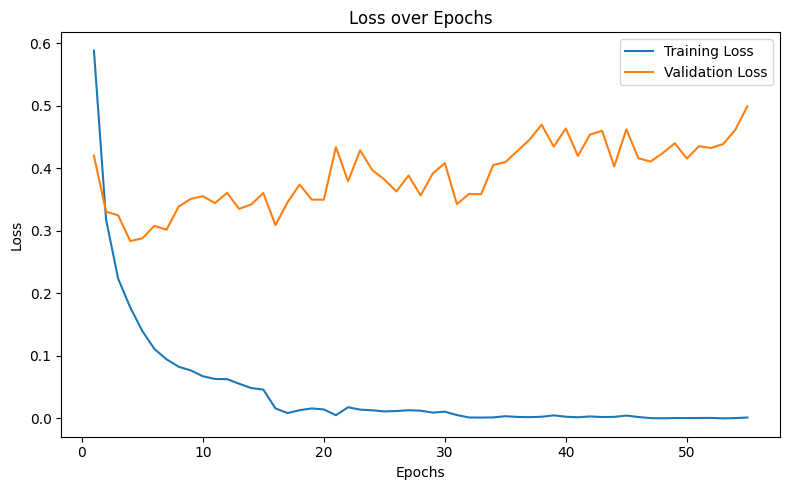

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epoch + 1), train_losses, label='Training Loss')
plt.plot(range(1, epoch + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
rec = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')
print("\nTest Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=testset.classes, zero_division=0))


Test Metrics:
Accuracy: 0.9270
Precision: 0.9270
Recall: 0.9270
F1-Score: 0.9268

Classification Report:
               precision    recall  f1-score   support

    airplane       0.93      0.94      0.93      1000
  automobile       0.97      0.94      0.96      1000
        bird       0.90      0.91      0.90      1000
         cat       0.88      0.82      0.85      1000
        deer       0.94      0.94      0.94      1000
         dog       0.89      0.89      0.89      1000
        frog       0.93      0.97      0.95      1000
       horse       0.96      0.94      0.95      1000
        ship       0.93      0.97      0.95      1000
       truck       0.95      0.95      0.95      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

